c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.25.2 and <2.6.0 is required for this version of SciPy (detected version 1.25.0)
  from scipy.stats import gaussian_kde


,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train


,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes


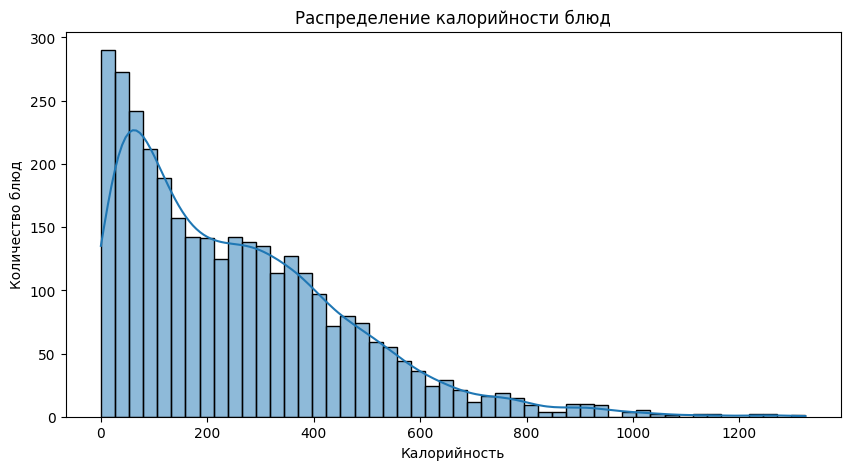

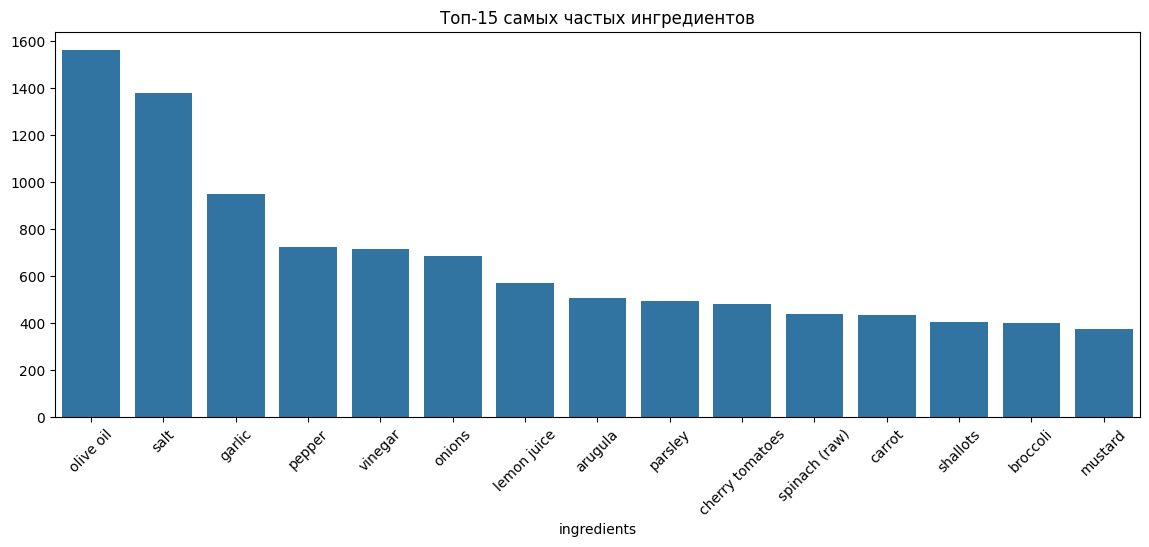

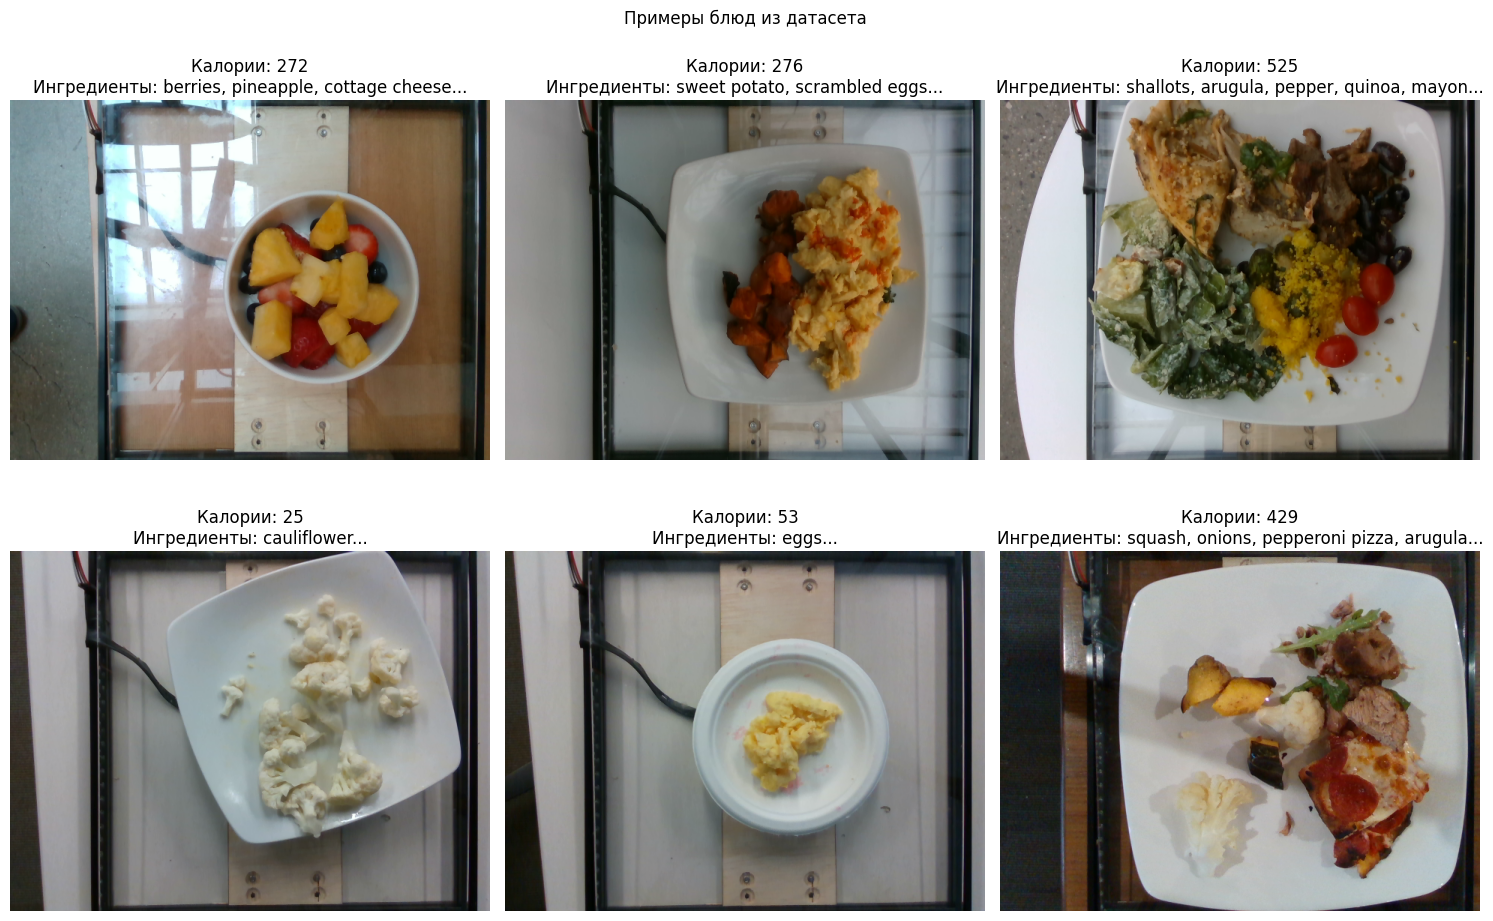

In [1]:
# Ячейка 1: Загрузка и визуализация данных для EDA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os


# Пути к данным
dish_csv = "data/dish.csv"
ingr_csv = "data/ingredients.csv"
images_root = "data/images"

# Загрузка csv
dish_df = pd.read_csv(dish_csv)
ingr_df = pd.read_csv(ingr_csv)

# Обзор таблиц
display(dish_df.head(), ingr_df.head())

# Распределение целевой переменной (калорийность)
filtered_calories = dish_df[dish_df['total_calories'] <= 3000]['total_calories']

plt.figure(figsize=(10,5))
sns.histplot(filtered_calories, bins=50, kde=True)
plt.title('Распределение калорийности блюд')
plt.xlabel('Калорийность')
plt.ylabel('Количество блюд')
plt.show()

# Пример нескольких ингредиентов: частотный топ 15 с реальными названиями
all_ingredients = dish_df['ingredients'].str.split(';').explode().dropna()

# Извлекаем последние ненулевые числа из ingr_0000000508 для сопоставления
def extract_id(ingr_str):
    if not ingr_str:
        return None
    return int(ingr_str.split('_')[-1])

ingredient_ids = all_ingredients.map(extract_id)

# Создаем словарь id -> название ингредиента
id_to_name = dict(zip(ingr_df['id'], ingr_df['ingr']))

# Маппим id к настоящим названиям
ingredient_names = ingredient_ids.map(id_to_name)

# Считаем топ 10 по названиям
ingredients_count = ingredient_names.value_counts().head(15)

plt.figure(figsize=(14,5))
sns.barplot(x=ingredients_count.index, y=ingredients_count.values)
plt.xticks(rotation=45)
plt.title('Топ-15 самых частых ингредиентов')
plt.show()

# Визуализация случайных изображений блюд с описанием ингредиентов и калорийностью
fig, axs = plt.subplots(2, 3, figsize=(15,10))
sample_dishes = dish_df.sample(6, random_state=42)

for ax, (_, row) in zip(axs.flatten(), sample_dishes.iterrows()):
    img_path = os.path.join(images_root, str(row['dish_id']), 'rgb.png')
    if os.path.exists(img_path):
        img = Image.open(img_path)
        ingr_ids = row['ingredients'].split(';')
        ingr_names = [ingr_df.loc[ingr_df['id'] == int(x.replace('ingr_', '')), 'ingr'].values[0] if x else '' for x in ingr_ids]
        text = ", ".join(ingr_names)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Калории: {row['total_calories']:.0f}\nИнгредиенты: {text[:40]}...")
plt.suptitle('Примеры блюд из датасета')
plt.tight_layout()
plt.show()


# Выводы о подходах к решению задачи

- Задача: регрессия — предсказание точной калорийности блюда на основе фото и текстового описания ингредиентов.

- Данные:  
  - Изображения блюд с разнообразными блюдами и качественной детализацией.  
  - Текстовое описание — список ингредиентов в формате ID. Важно корректно сопоставить и токенизировать ингредиенты.

- Аугментации и обогащение данных:  
  - Для изображений применим геометрические преобразования (повороты, горизонтальные и вертикальные отражения), чтобы повысить устойчивость к различному положению и ориентации.  
  - Brightness, contrast, размытие и шум помогут справиться с вариациями освещения и шума камеры.  
  - Аффинные трансформации добавят инвариантности к небольшим искажениям формы.  
  - Для текстов предусмотреть токенизацию правильно, возможно расширить словарь или сделать эмбеддинги по имени ингредиентов.

- Метрики и обучение:  
  - Ключевая метрика — MAE (Mean Absolute Error), которая показывается среднюю абсолютную ошибку прогнозируемой калорийности.  
  - Используется регрессионная модель с выводом одного числа, что проще для интерпретации и точной оценки, чем классификация.  

- Общая стратегия:  
  - Использовать мультимодальную модель (текст + изображение).  
  - Объединять эмбеддинги из текстового и визуального модулей через конкатенацию для максимального сочетания признаков.  
  - Тщательно настраивать аугментации для улучшения обобщающей способности и устойчивости модели.


In [2]:
# Обучение модели.
from src.train import train

# Запуск обучения.
train_loss, val_maes = train()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\check_version.py:147: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()


Train samples: 2755
Val samples: 507


100%|██████████| 87/87 [00:54<00:00,  1.58it/s]


Epoch 1: Train Loss 206.5840, Val MAE 154.4751


100%|██████████| 87/87 [00:52<00:00,  1.65it/s]


Epoch 2: Train Loss 105.3568, Val MAE 80.5037


100%|██████████| 87/87 [00:52<00:00,  1.66it/s]


Epoch 3: Train Loss 70.9578, Val MAE 72.6169


100%|██████████| 87/87 [00:52<00:00,  1.67it/s]


Epoch 4: Train Loss 59.6152, Val MAE 68.6122


100%|██████████| 87/87 [00:53<00:00,  1.63it/s]


Epoch 5: Train Loss 56.7478, Val MAE 67.6735


100%|██████████| 87/87 [00:52<00:00,  1.64it/s]


Epoch 6: Train Loss 51.8316, Val MAE 65.0564


100%|██████████| 87/87 [00:53<00:00,  1.63it/s]


Epoch 7: Train Loss 49.4056, Val MAE 60.3058


100%|██████████| 87/87 [00:52<00:00,  1.66it/s]


Epoch 8: Train Loss 47.6894, Val MAE 63.5584


100%|██████████| 87/87 [00:50<00:00,  1.73it/s]


Epoch 9: Train Loss 44.4253, Val MAE 54.3827


100%|██████████| 87/87 [00:50<00:00,  1.73it/s]


Epoch 10: Train Loss 43.1381, Val MAE 56.5466


100%|██████████| 87/87 [00:49<00:00,  1.75it/s]


Epoch 11: Train Loss 41.4889, Val MAE 53.5493


100%|██████████| 87/87 [00:51<00:00,  1.69it/s]


Epoch 12: Train Loss 40.5132, Val MAE 53.2164


100%|██████████| 87/87 [00:53<00:00,  1.64it/s]


Epoch 13: Train Loss 38.0526, Val MAE 49.9702


100%|██████████| 87/87 [00:52<00:00,  1.64it/s]


Epoch 14: Train Loss 36.5132, Val MAE 51.4681


100%|██████████| 87/87 [00:51<00:00,  1.68it/s]


Epoch 15: Train Loss 35.0142, Val MAE 51.6847


100%|██████████| 87/87 [00:50<00:00,  1.72it/s]


Epoch 16: Train Loss 34.1943, Val MAE 47.8993


100%|██████████| 87/87 [00:51<00:00,  1.70it/s]


Epoch 17: Train Loss 33.5797, Val MAE 51.1231


100%|██████████| 87/87 [00:51<00:00,  1.69it/s]


Epoch 18: Train Loss 32.1377, Val MAE 49.7740


100%|██████████| 87/87 [00:50<00:00,  1.72it/s]


Epoch 19: Train Loss 33.2310, Val MAE 51.8159


100%|██████████| 87/87 [00:50<00:00,  1.71it/s]


Epoch 20: Train Loss 31.1127, Val MAE 48.7792


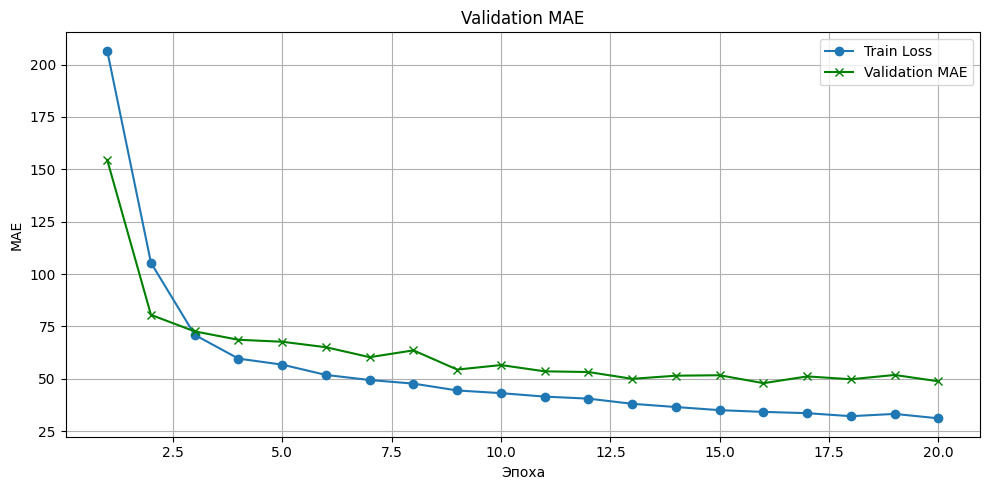

In [3]:
# Визуализация метрик.

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 5))

# График потерь обучения
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.grid(True)

# График MAE на валидации
plt.plot(epochs, val_maes, marker='x', color='green', label='Validation MAE')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# Инференс модели.
import torch
from src.dataset import MultimodalCalorieDataset, collate_fn, get_transforms
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from functools import partial
from src.train import MultimodalModel
from src.train import Config 


# Загрузка весов и подготовка модели
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultimodalModel(Config)
model.load_state_dict(torch.load(Config.SAVE_PATH, map_location=device))
model.to(device)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(Config.TEXT_MODEL_NAME)

# Подготовка тестового датасета и загрузчика
test_dataset = MultimodalCalorieDataset(Config, get_transforms(Config, ds_type="val"), split="test")
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False,
                         collate_fn=partial(collate_fn, tokenizer=tokenizer))

# Инференс и сбор метрик
import numpy as np

all_preds = []
all_labels = []
all_dish_ids = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {k: batch[k].to(device) for k in ["input_ids", "attention_mask", "image", "mass"]}
        labels = batch["label"].to(device)
        preds = model(**inputs)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Получить dish_id из индексов
        # Пример:
        batch_size = len(preds)
        start_idx = len(all_preds) - batch_size
        dish_ids = test_dataset.df.iloc[start_idx:start_idx + batch_size]['dish_id'].values
        all_dish_ids.extend(dish_ids)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_dish_ids = np.array(all_dish_ids)

mae = np.mean(np.abs(all_preds - all_labels))
print(f"Final MAE on test set: {mae:.4f}")

errors = np.abs(all_preds - all_labels)
worst_indices = np.argsort(-errors)[:5]
print("Top-5 наименее точных блюд:")
for i in worst_indices:
    print(f"dish_id: {all_dish_ids[i]}, Предсказано: {all_preds[i]:.2f}, Истина: {all_labels[i]:.2f}, Ошибка: {errors[i]:.2f}")


Final MAE on test set: 47.8993
Top-5 наименее точных блюд:
dish_id: dish_1558549806, Предсказано: 372.50, Истина: 781.96, Ошибка: 409.46
dish_id: dish_1558720236, Предсказано: 479.03, Истина: 887.82, Ошибка: 408.80
dish_id: dish_1558375886, Предсказано: 643.34, Истина: 1050.51, Ошибка: 407.17
dish_id: dish_1558630325, Предсказано: 359.31, Истина: 751.54, Ошибка: 392.23
dish_id: dish_1566328831, Предсказано: 559.72, Истина: 941.61, Ошибка: 381.89


## Анализ топ-5 наименее точных предсказаний модели

### Основные причины высокой ошибки:

1. **Длинный «хвост» калорийности / редкие блюда**  
   Некоторые блюда имеют экстремально высокую калорийность и сильно выбиваются из распределения. Модель плохо обучается на редких значениях, поэтому предсказывает их с большой погрешностью.

2. **Неоднозначная визуальная информация**  
   Блюдо содержит мало отличительных визуальных признаков или ингредиенты визуально похожи на менее калорийные блюда, CV-модель может ошибаться при оценке калорийности.

3. **Сложные комбинации ингредиентов**  
   Большое количество ингредиентов или редкие сочетания плохо кодируются текстовой моделью, что ведёт к неточным предсказаниям.